# Отчет по лабораторной работе №3: Классификация. Нейронные сети

Выполнил: Ищенко С.Г., Группа АП-226

## 1. Введение

**Цель работы:** изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

В рамках данной лабораторной работы будут построены классификационные модели с помощью пяти различных методов: Наивный Байесовский классификатор, Деревья решений, Линейный дискриминантный анализ, Метод опорных векторов и Метод ближайших соседей. Будет проведено сравнение качества работы классификаторов с использованием ключевых метрик (Accuracy, Precision, Recall, F1-Score, AUC-ROC). Особое внимание будет уделено настройке гиперпараметров каждого метода и исследованию их влияния на качество классификации.

Помимо этого, будет реализована и протестирована нейронная сеть на TensorFlow, включая исследование эффекта настройки гиперпараметров и визуализацию процесса обучения с помощью инструмента TensorBoard. При возможности будет выполнена опциональная часть по кросс-валидации и Grid Search для нейронной сети.



## 2. Выбор и подготовка датасета

В этой секции представлен выбранный датасет, его характеристики, описание признаков и целевой переменной, а также шаги по его предобработке для дальнейшего использования в классификационных моделях.



### 2.1 Загрузка и первичный анализ данных

Здесь мы загружаем датасет `Pima Indians Diabetes Database`, проводим первичный осмотр данных, выводим первые строки, общую информацию и статистическое описание.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import datetime
import shutil # Добавляем импорт shutil для удаления директорий

# Фиксируем seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

# Загрузка данных
data_path = 'data/diabetes.csv'
df = pd.read_csv(data_path)

print("Первые 5 строк датасета:")
print(df.head())

print("\nОбщая информация о датасете:")
print(df.info())

print("\nСтатистическое описание датасета:")
print(df.describe())

def prepare_log_dir(base_dir, model_name):
    """
    Подготавливает директорию для логов TensorBoard, удаляя старые логи, если они существуют,
    и создавая новую директорию с отметкой времени.
    """
    log_dir = os.path.join(base_dir, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # Удаляем старую директорию, если она существует (для избежания FailedPreconditionError)
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    
    os.makedirs(log_dir, exist_ok=True)
    return log_dir



C:\Users\SergoSektor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SergoSektor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SergoSektor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\

Первые 5 строк датасета:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768

### 2.2 Предобработка данных

На этом этапе мы займемся обработкой пропущенных значений (если таковые имеются), заменой нелогичных нулевых значений (например, для уровня глюкозы или давления), а также масштабированием признаков для подготовки данных к обучению моделей.



In [2]:
# Замена 0 на NaN в соответствующих столбцах, так как 0 здесь означает пропущенное значение
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

print("\nКоличество пропущенных значений после замены 0 на NaN:")
print(df.isnull().sum())

# Заполнение пропущенных значений медианой
for col in columns_with_zeros:
    df[col] = df[col].fillna(df[col].median())

print("\nКоличество пропущенных значений после импутации:")
print(df.isnull().sum())

# Разделение на признаки (X) и целевую переменную (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nПервые 5 строк масштабированного датасета (X_scaled_df):")
print(X_scaled_df.head())




Количество пропущенных значений после замены 0 на NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Количество пропущенных значений после импутации:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Первые 5 строк масштабированного датасета (X_scaled_df):
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.866045      -0.031990       0.670643 -0.181541  0.166619   
1    -0.844885 -1.205066      -0.528319      -0.012301 -0.181541 -0.852200   
2     1.233880  2.

## 3. Разбиение выборки

В этом разделе мы разделим предобработанный датасет на обучающий и тестовый наборы. Это необходимо для того, чтобы оценить обобщающую способность наших классификационных моделей на данных, которые они "не видели" в процессе обучения. Обычно используется соотношение 70/30 или 80/20 для обучения и тестирования соответственно.



In [3]:
# Разбиение данных на обучающую и тестовую выборки (70% обучение, 30% тестирование)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42, stratify=y)

print(f"Размер обучающей выборки X_train: {X_train.shape}")
print(f"Размер тестовой выборки X_test: {X_test.shape}")
print(f"Распределение классов в y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Распределение классов в y_test:\n{y_test.value_counts(normalize=True)}")

# Определение базовой архитектуры нейронной сети
def create_model():
    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)), # Используем Input слой для указания input_shape
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Размер обучающей выборки X_train: (537, 8)
Размер тестовой выборки X_test: (231, 8)
Распределение классов в y_train:
Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64
Распределение классов в y_test:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,473 (37.00 KB)

 Trainable params: 9,473 (37.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Методы классификации

В этом разделе будут реализованы и протестированы пять различных методов классификации из библиотеки Scikit-Learn: Наивный Байесовский классификатор, Деревья решений, Линейный дискриминантный анализ, Метод опорных векторов и Метод ближайших соседей. Для каждого метода будет проведена оценка качества с помощью метрик Accuracy, Precision, Recall, F1-Score и AUC-ROC.



### 4.1 Наивный Байесовский классификатор

Рассмотрим различные варианты Наивного Байесовского классификатора (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB) и оценим их производительность на нашем датасете.



In [ ]:
classifiers = {
    "GaussianNB": GaussianNB(),
    # "MultinomialNB": MultinomialNB(), # Требует неотрицательных признаков, не подходит для масштабированных данных
    # "ComplementNB": ComplementNB(),   # Требует неотрицательных признаков, не подходит для масштабированных данных
    "BernoulliNB": BernoulliNB()
}

results = []

for name, classifier in classifiers.items():
    print(f"\n--- {name} ---")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1] # Вероятности для ROC AUC
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

# Для MultinomialNB и ComplementNB требуются неотрицательные признаки. 
# Если хотим их использовать, нужно применить MinMaxScaler вместо StandardScaler или использовать другие стратегии. 
# Пока что пропускаем их для масштабированных данных.




--- GaussianNB ---
Accuracy: 0.7273
Precision: 0.6184
Recall: 0.5802
F1-Score: 0.5987
ROC AUC: 0.8040

--- BernoulliNB ---
Accuracy: 0.7143
Precision: 0.6119
Recall: 0.5062
F1-Score: 0.5541
ROC AUC: 0.7895


### 4.2 Деревья решений

Реализуем и оценим классификатор на основе Деревьев решений.



In [5]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
y_prob_dt = dt_classifier.predict_proba(X_test)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)

print("\n--- Decision Tree ---")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")

results.append({
    'Classifier': 'Decision Tree',
    'Accuracy': accuracy_dt,
    'Precision': precision_dt,
    'Recall': recall_dt,
    'F1-Score': f1_dt,
    'ROC AUC': roc_auc_dt
})




--- Decision Tree ---
Accuracy: 0.6883
Precision: 0.5584
Recall: 0.5309
F1-Score: 0.5443
ROC AUC: 0.6521


### 4.3 Линейный дискриминантный анализ (LDA)

Реализуем и оценим классификатор на основе Линейного дискриминантного анализа.



In [6]:
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred_lda = lda_classifier.predict(X_test)
y_prob_lda = lda_classifier.predict_proba(X_test)[:, 1]

accuracy_lda = accuracy_score(y_test, y_pred_lda)
precision_lda = precision_score(y_test, y_pred_lda)
recall_lda = recall_score(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda)
roc_auc_lda = roc_auc_score(y_test, y_prob_lda)

print("\n--- Linear Discriminant Analysis ---")
print(f"Accuracy: {accuracy_lda:.4f}")
print(f"Precision: {precision_lda:.4f}")
print(f"Recall: {recall_lda:.4f}")
print(f"F1-Score: {f1_lda:.4f}")
print(f"ROC AUC: {roc_auc_lda:.4f}")

results.append({
    'Classifier': 'Linear Discriminant Analysis',
    'Accuracy': accuracy_lda,
    'Precision': precision_lda,
    'Recall': recall_lda,
    'F1-Score': f1_lda,
    'ROC AUC': roc_auc_lda
})




--- Linear Discriminant Analysis ---
Accuracy: 0.7359
Precision: 0.6613
Recall: 0.5062
F1-Score: 0.5734
ROC AUC: 0.8347


### 4.4 Метод опорных векторов (Support Vector Machines)

Реализуем и оценим классификатор на основе Метода опорных векторов.



In [7]:
svm_classifier = SVC(random_state=42, probability=True) # probability=True для roc_auc_score
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
y_prob_svm = svm_classifier.predict_proba(X_test)[:, 1]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

print("\n--- Support Vector Machine ---")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"ROC AUC: {roc_auc_svm:.4f}")

results.append({
    'Classifier': 'Support Vector Machine',
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm,
    'ROC AUC': roc_auc_svm
})




--- Support Vector Machine ---
Accuracy: 0.7446
Precision: 0.6774
Recall: 0.5185
F1-Score: 0.5874
ROC AUC: 0.8171


### 4.5 Метод ближайших соседей (k-Nearest Neighbors)

Реализуем и оценим классификатор на основе Метода ближайших соседей.



In [8]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
y_prob_knn = knn_classifier.predict_proba(X_test)[:, 1]

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

print("\n--- k-Nearest Neighbors ---")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}")
print(f"ROC AUC: {roc_auc_knn:.4f}")

results.append({
    'Classifier': 'k-Nearest Neighbors',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1-Score': f1_knn,
    'ROC AUC': roc_auc_knn
})




--- k-Nearest Neighbors ---
Accuracy: 0.7489
Precision: 0.6620
Recall: 0.5802
F1-Score: 0.6184
ROC AUC: 0.8019


### 4.6 Сравнение результатов классификаторов

Сведем полученные метрики всех классификаторов в одну таблицу для удобного сравнения и визуализируем их.




Сводная таблица метрик качества классификаторов:
                     Classifier  Accuracy  Precision    Recall  F1-Score  \
0                    GaussianNB  0.727273   0.618421  0.580247  0.598726   
1                   BernoulliNB  0.714286   0.611940  0.506173  0.554054   
2                 Decision Tree  0.688312   0.558442  0.530864  0.544304   
3  Linear Discriminant Analysis  0.735931   0.661290  0.506173  0.573427   
4        Support Vector Machine  0.744589   0.677419  0.518519  0.587413   
5           k-Nearest Neighbors  0.748918   0.661972  0.580247  0.618421   

    ROC AUC  
0  0.803951  
1  0.789547  
2  0.652099  
3  0.834733  
4  0.817119  
5  0.801893  


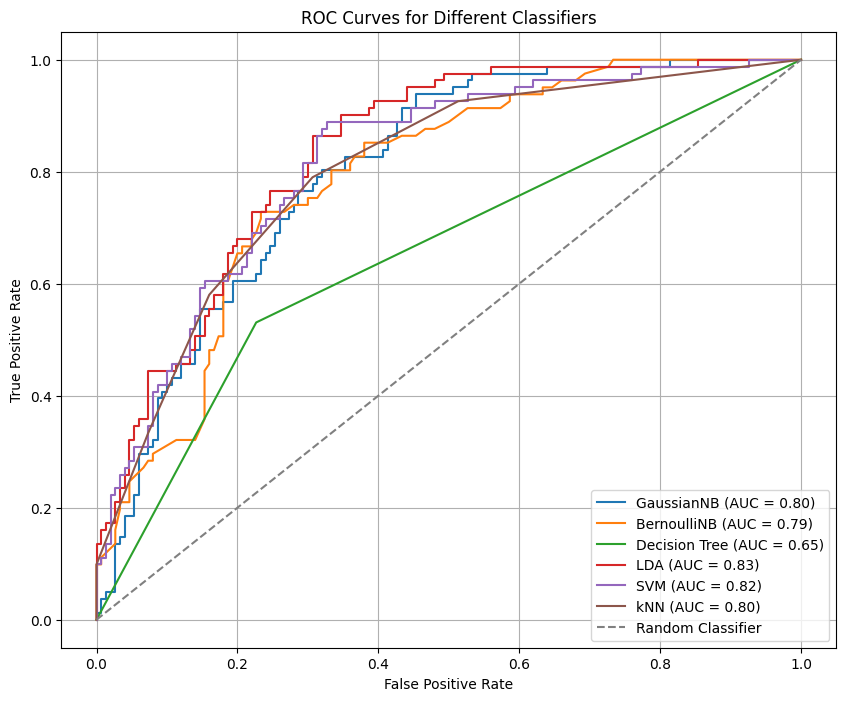

C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\4131380871.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\4131380871.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\4131380871.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\4131380871.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

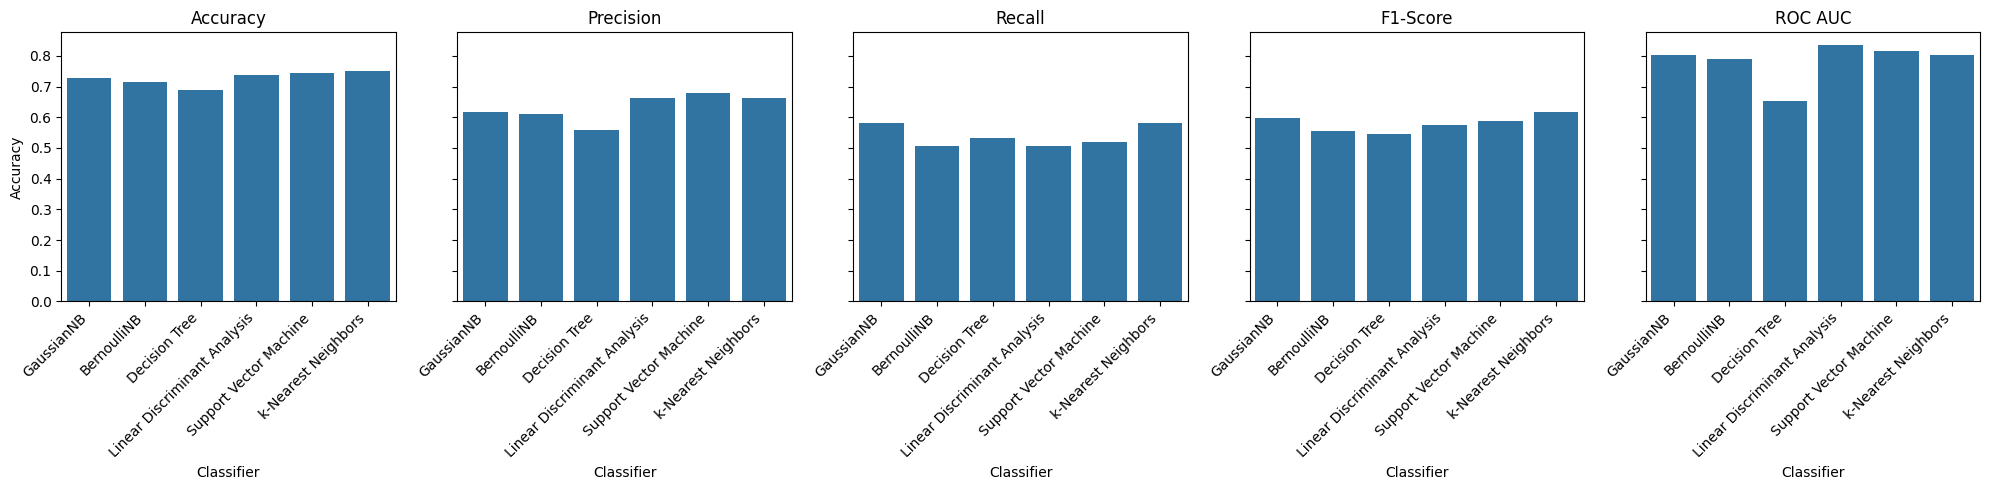

In [ ]:
results_df = pd.DataFrame(results)
print("\nСводная таблица метрик качества классификаторов:")
print(results_df)

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))

# Для GaussianNB
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, classifiers["GaussianNB"].predict_proba(X_test)[:, 1])
plt.plot(fpr_gnb, tpr_gnb, label=f'GaussianNB (AUC = {roc_auc_score(y_test, classifiers["GaussianNB"].predict_proba(X_test)[:, 1]):.2f})')

# Для BernoulliNB
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, classifiers["BernoulliNB"].predict_proba(X_test)[:, 1])
plt.plot(fpr_bnb, tpr_bnb, label=f'BernoulliNB (AUC = {roc_auc_score(y_test, classifiers["BernoulliNB"].predict_proba(X_test)[:, 1]):.2f})')

# Для Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Для LDA
fpr_lda, tpr_lda, _ = roc_curve(y_test, lda_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.2f})')

# Для SVM (нужно получить y_prob_svm из соответствующей ячейки)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Для kNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, label=f'kNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.grid(True)
plt.show()

# Визуализация метрик на столбчатых диаграммах
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x='Classifier', y=metric, data=results_df, ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_xticklabels(results_df['Classifier'], rotation=45, ha='right')

plt.tight_layout()
plt.show()



## 5. Настройка гиперпараметров

В этой секции будет проведена настройка гиперпараметров для каждого из рассмотренных методов классификации. Мы будем использовать `GridSearchCV` для поиска оптимальных параметров, а затем оценим влияние этих изменений на качество классификации.



### 5.1 Наивный Байесовский классификатор (GaussianNB, BernoulliNB)

Настроим гиперпараметры для GaussianNB (параметр `var_smoothing`) и BernoulliNB (параметр `alpha`).



In [10]:
# Настройка GaussianNB
param_grid_gnb = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_search_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gnb.fit(X_train, y_train)

best_gnb = grid_search_gnb.best_estimator_
print(f"\nЛучшие параметры для GaussianNB: {grid_search_gnb.best_params_}")
y_pred_gnb_tuned = best_gnb.predict(X_test)
y_prob_gnb_tuned = best_gnb.predict_proba(X_test)[:, 1]

accuracy_gnb_tuned = accuracy_score(y_test, y_pred_gnb_tuned)
precision_gnb_tuned = precision_score(y_test, y_pred_gnb_tuned)
recall_gnb_tuned = recall_score(y_test, y_pred_gnb_tuned)
f1_gnb_tuned = f1_score(y_test, y_pred_gnb_tuned)
roc_auc_gnb_tuned = roc_auc_score(y_test, y_prob_gnb_tuned)

print(f"GaussianNB (tuned) Accuracy: {accuracy_gnb_tuned:.4f}")
print(f"GaussianNB (tuned) ROC AUC: {roc_auc_gnb_tuned:.4f}")

results.append({
    'Classifier': 'GaussianNB (tuned)',
    'Accuracy': accuracy_gnb_tuned,
    'Precision': precision_gnb_tuned,
    'Recall': recall_gnb_tuned,
    'F1-Score': f1_gnb_tuned,
    'ROC AUC': roc_auc_gnb_tuned
})

# Настройка BernoulliNB
param_grid_bnb = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
grid_search_bnb = GridSearchCV(BernoulliNB(), param_grid_bnb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_bnb.fit(X_train, y_train)

best_bnb = grid_search_bnb.best_estimator_
print(f"\nЛучшие параметры для BernoulliNB: {grid_search_bnb.best_params_}")
y_pred_bnb_tuned = best_bnb.predict(X_test)
y_prob_bnb_tuned = best_bnb.predict_proba(X_test)[:, 1]

accuracy_bnb_tuned = accuracy_score(y_test, y_pred_bnb_tuned)
precision_bnb_tuned = precision_score(y_test, y_pred_bnb_tuned)
recall_bnb_tuned = recall_score(y_test, y_pred_bnb_tuned)
f1_bnb_tuned = f1_score(y_test, y_pred_bnb_tuned)
roc_auc_bnb_tuned = roc_auc_score(y_test, y_prob_bnb_tuned)

print(f"BernoulliNB (tuned) Accuracy: {accuracy_bnb_tuned:.4f}")
print(f"BernoulliNB (tuned) ROC AUC: {roc_auc_bnb_tuned:.4f}")

results.append({
    'Classifier': 'BernoulliNB (tuned)',
    'Accuracy': accuracy_bnb_tuned,
    'Precision': precision_bnb_tuned,
    'Recall': recall_bnb_tuned,
    'F1-Score': f1_bnb_tuned,
    'ROC AUC': roc_auc_bnb_tuned
})




Лучшие параметры для GaussianNB: {'var_smoothing': np.float64(1.0)}
GaussianNB (tuned) Accuracy: 0.7403
GaussianNB (tuned) ROC AUC: 0.8133

Лучшие параметры для BernoulliNB: {'alpha': 0.5}
BernoulliNB (tuned) Accuracy: 0.7143
BernoulliNB (tuned) ROC AUC: 0.7895


### 5.2 Деревья решений

Настроим гиперпараметры для `DecisionTreeClassifier`, включая `max_depth`, `min_samples_split` и `min_samples_leaf`.



In [11]:
# Настройка Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_
print(f"\nЛучшие параметры для Decision Tree: {grid_search_dt.best_params_}")
y_pred_dt_tuned = best_dt.predict(X_test)
y_prob_dt_tuned = best_dt.predict_proba(X_test)[:, 1]

accuracy_dt_tuned = accuracy_score(y_test, y_pred_dt_tuned)
precision_dt_tuned = precision_score(y_test, y_pred_dt_tuned)
recall_dt_tuned = recall_score(y_test, y_pred_dt_tuned)
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned)
roc_auc_dt_tuned = roc_auc_score(y_test, y_prob_dt_tuned)

print(f"Decision Tree (tuned) Accuracy: {accuracy_dt_tuned:.4f}")
print(f"Decision Tree (tuned) ROC AUC: {roc_auc_dt_tuned:.4f}")

results.append({
    'Classifier': 'Decision Tree (tuned)',
    'Accuracy': accuracy_dt_tuned,
    'Precision': precision_dt_tuned,
    'Recall': recall_dt_tuned,
    'F1-Score': f1_dt_tuned,
    'ROC AUC': roc_auc_dt_tuned
})




Лучшие параметры для Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree (tuned) Accuracy: 0.7229
Decision Tree (tuned) ROC AUC: 0.7530


### 5.3 Линейный дискриминантный анализ (LDA)

Настроим гиперпараметры для `LinearDiscriminantAnalysis`, в частности `solver` и `shrinkage`.



In [12]:
# Настройка LDA
param_grid_lda = [
    {'solver': ['svd'], 'shrinkage': [None]},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': np.arange(0.0, 1.1, 0.1)}
]
grid_search_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid_lda, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_lda.fit(X_train, y_train)

best_lda = grid_search_lda.best_estimator_
print(f"\nЛучшие параметры для LDA: {grid_search_lda.best_params_}")
y_pred_lda_tuned = best_lda.predict(X_test)
y_prob_lda_tuned = best_lda.predict_proba(X_test)[:, 1]

accuracy_lda_tuned = accuracy_score(y_test, y_pred_lda_tuned)
precision_lda_tuned = precision_score(y_test, y_pred_lda_tuned)
recall_lda_tuned = recall_score(y_test, y_pred_lda_tuned)
f1_lda_tuned = f1_score(y_test, y_pred_lda_tuned)
roc_auc_lda_tuned = roc_auc_score(y_test, y_prob_lda_tuned)

print(f"LDA (tuned) Accuracy: {accuracy_lda_tuned:.4f}")
print(f"LDA (tuned) ROC AUC: {roc_auc_lda_tuned:.4f}")

results.append({
    'Classifier': 'LDA (tuned)',
    'Accuracy': accuracy_lda_tuned,
    'Precision': precision_lda_tuned,
    'Recall': recall_lda_tuned,
    'F1-Score': f1_lda_tuned,
    'ROC AUC': roc_auc_lda_tuned
})




Лучшие параметры для LDA: {'shrinkage': np.float64(0.2), 'solver': 'lsqr'}
LDA (tuned) Accuracy: 0.7446
LDA (tuned) ROC AUC: 0.8374


### 5.4 Метод опорных векторов (SVM)

Настроим гиперпараметры для `SVC`, включая `C`, `kernel` и `gamma`.



In [13]:
# Настройка SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale']
}
grid_search_svm = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
print(f"\nЛучшие параметры для SVM: {grid_search_svm.best_params_}")
y_pred_svm_tuned = best_svm.predict(X_test)
y_prob_svm_tuned = best_svm.predict_proba(X_test)[:, 1]

accuracy_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)
precision_svm_tuned = precision_score(y_test, y_pred_svm_tuned)
recall_svm_tuned = recall_score(y_test, y_pred_svm_tuned)
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned)
roc_auc_svm_tuned = roc_auc_score(y_test, y_prob_svm_tuned)

print(f"SVM (tuned) Accuracy: {accuracy_svm_tuned:.4f}")
print(f"SVM (tuned) ROC AUC: {roc_auc_svm_tuned:.4f}")

results.append({
    'Classifier': 'SVM (tuned)',
    'Accuracy': accuracy_svm_tuned,
    'Precision': precision_svm_tuned,
    'Recall': recall_svm_tuned,
    'F1-Score': f1_svm_tuned,
    'ROC AUC': roc_auc_svm_tuned
})




Лучшие параметры для SVM: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
SVM (tuned) Accuracy: 0.7273
SVM (tuned) ROC AUC: 0.8321


### 5.5 Метод ближайших соседей (kNN)

Настроим гиперпараметры для `KNeighborsClassifier`, включая `n_neighbors` и `weights`.



In [14]:
# Настройка kNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

best_knn = grid_search_knn.best_estimator_
print(f"\nЛучшие параметры для kNN: {grid_search_knn.best_params_}")
y_pred_knn_tuned = best_knn.predict(X_test)
y_prob_knn_tuned = best_knn.predict_proba(X_test)[:, 1]

accuracy_knn_tuned = accuracy_score(y_test, y_pred_knn_tuned)
precision_knn_tuned = precision_score(y_test, y_pred_knn_tuned)
recall_knn_tuned = recall_score(y_test, y_pred_knn_tuned)
f1_knn_tuned = f1_score(y_test, y_pred_knn_tuned)
roc_auc_knn_tuned = roc_auc_score(y_test, y_prob_knn_tuned)

print(f"kNN (tuned) Accuracy: {accuracy_knn_tuned:.4f}")
print(f"kNN (tuned) ROC AUC: {roc_auc_knn_tuned:.4f}")

results.append({
    'Classifier': 'kNN (tuned)',
    'Accuracy': accuracy_knn_tuned,
    'Precision': precision_knn_tuned,
    'Recall': recall_knn_tuned,
    'F1-Score': f1_knn_tuned,
    'ROC AUC': roc_auc_knn_tuned
})




Лучшие параметры для kNN: {'n_neighbors': 9, 'weights': 'distance'}
kNN (tuned) Accuracy: 0.7316
kNN (tuned) ROC AUC: 0.8102


### 5.6 Сравнение результатов классификаторов после настройки гиперпараметров

Сведем обновленные метрики всех классификаторов в одну таблицу для удобного сравнения и визуализируем их.




Сводная таблица метрик качества классификаторов после тюнинга:
                      Classifier  Accuracy  Precision    Recall  F1-Score  \
0                     GaussianNB  0.727273   0.618421  0.580247  0.598726   
1                    BernoulliNB  0.714286   0.611940  0.506173  0.554054   
2                  Decision Tree  0.688312   0.558442  0.530864  0.544304   
3   Linear Discriminant Analysis  0.735931   0.661290  0.506173  0.573427   
4         Support Vector Machine  0.744589   0.677419  0.518519  0.587413   
5            k-Nearest Neighbors  0.748918   0.661972  0.580247  0.618421   
6             GaussianNB (tuned)  0.740260   0.690909  0.469136  0.558824   
7            BernoulliNB (tuned)  0.714286   0.611940  0.506173  0.554054   
8          Decision Tree (tuned)  0.722944   0.616438  0.555556  0.584416   
9                    LDA (tuned)  0.744589   0.661765  0.555556  0.604027   
10                   SVM (tuned)  0.727273   0.655172  0.469136  0.546763   
11          

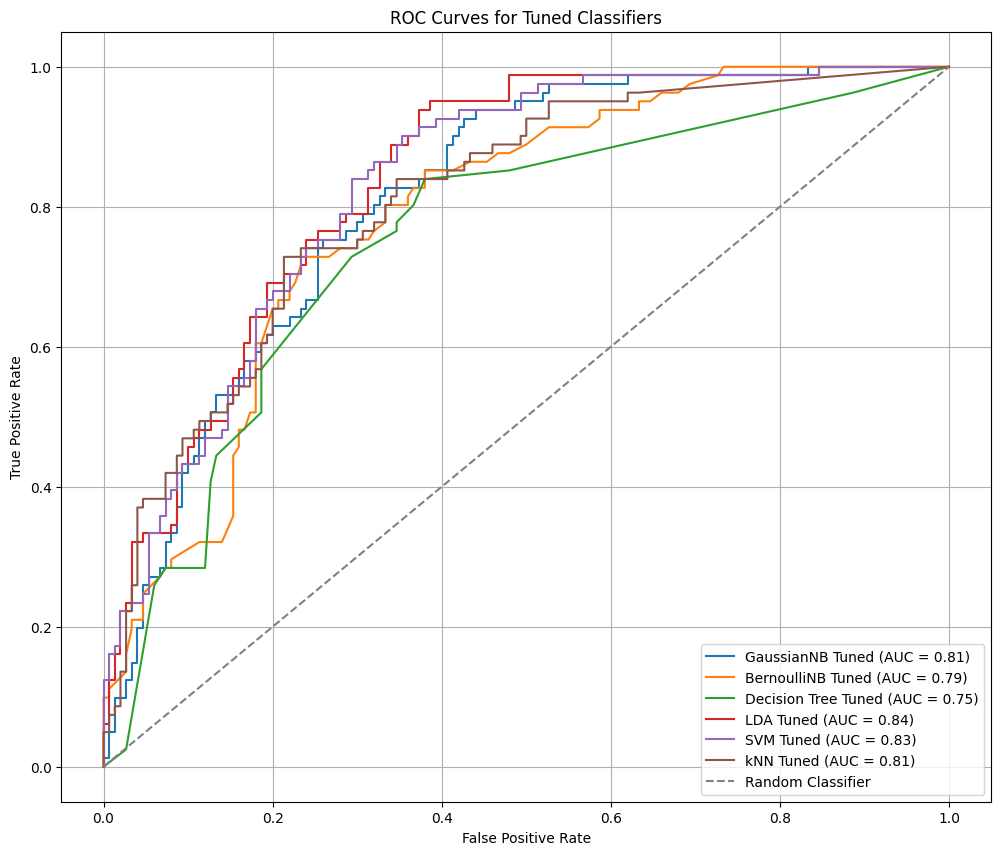

C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\369331421.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df_tuned['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\369331421.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df_tuned['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\369331421.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df_tuned['Classifier'], rotation=45, ha='right')
C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_8340\369331421.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

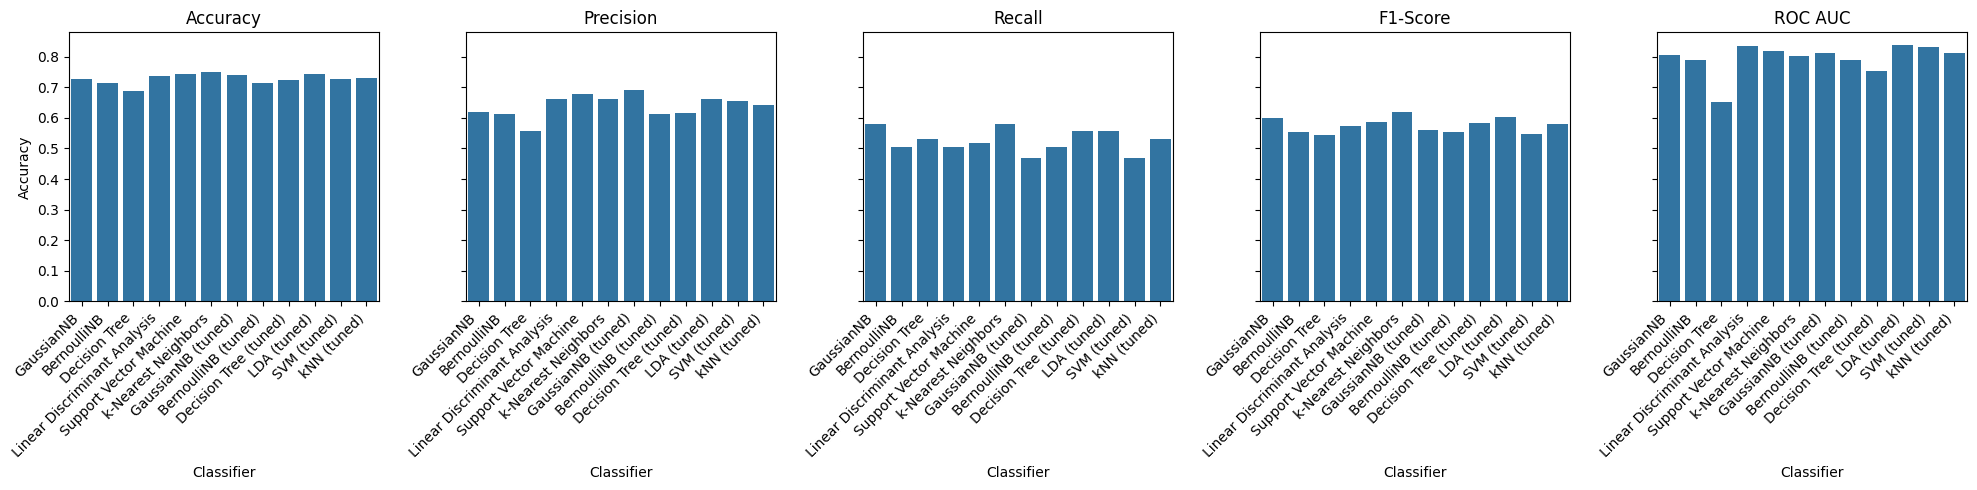

In [ ]:
results_df_tuned = pd.DataFrame(results)
print("\nСводная таблица метрик качества классификаторов после тюнинга:")
print(results_df_tuned)

# Визуализация ROC-кривых после тюнинга
plt.figure(figsize=(12, 10))

# Для GaussianNB (tuned)
fpr_gnb_tuned, tpr_gnb_tuned, _ = roc_curve(y_test, best_gnb.predict_proba(X_test)[:, 1])
plt.plot(fpr_gnb_tuned, tpr_gnb_tuned, label=f'GaussianNB Tuned (AUC = {roc_auc_gnb_tuned:.2f})')

# Для BernoulliNB (tuned)
fpr_bnb_tuned, tpr_bnb_tuned, _ = roc_curve(y_test, best_bnb.predict_proba(X_test)[:, 1])
plt.plot(fpr_bnb_tuned, tpr_bnb_tuned, label=f'BernoulliNB Tuned (AUC = {roc_auc_bnb_tuned:.2f})')

# Для Decision Tree (tuned)
fpr_dt_tuned, tpr_dt_tuned, _ = roc_curve(y_test, best_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt_tuned, tpr_dt_tuned, label=f'Decision Tree Tuned (AUC = {roc_auc_dt_tuned:.2f})')

# Для LDA (tuned)
fpr_lda_tuned, tpr_lda_tuned, _ = roc_curve(y_test, best_lda.predict_proba(X_test)[:, 1])
plt.plot(fpr_lda_tuned, tpr_lda_tuned, label=f'LDA Tuned (AUC = {roc_auc_lda_tuned:.2f})')

# Для SVM (tuned)
fpr_svm_tuned, tpr_svm_tuned, _ = roc_curve(y_test, best_svm.predict_proba(X_test)[:, 1])
plt.plot(fpr_svm_tuned, tpr_svm_tuned, label=f'SVM Tuned (AUC = {roc_auc_svm_tuned:.2f})')

# Для kNN (tuned)
fpr_knn_tuned, tpr_knn_tuned, _ = roc_curve(y_test, best_knn.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn_tuned, tpr_knn_tuned, label=f'kNN Tuned (AUC = {roc_auc_knn_tuned:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Classifiers')
plt.legend()
plt.grid(True)
plt.show()

# Визуализация метрик на столбчатых диаграммах после тюнинга
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x='Classifier', y=metric, data=results_df_tuned, ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_xticklabels(results_df_tuned['Classifier'], rotation=45, ha='right')

plt.tight_layout()
plt.show()



## 6. Нейронные сети с использованием TensorFlow

В этом разделе мы реализуем базовую нейронную сеть, а также проведем ручную настройку гиперпараметров для улучшения ее производительности. Для мониторинга процесса обучения будет использоваться TensorBoard.



### 6.1 Базовая нейронная сеть

Обучим базовую нейронную сеть и оценим ее производительность. Логи обучения будут записаны для просмотра в TensorBoard.



In [16]:
import os
import shutil
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# -----------------------------
# Очистка логов TensorBoard
# -----------------------------
log_base_dir = "logs/fit"
if os.path.exists(log_base_dir):
    shutil.rmtree(log_base_dir)  # полностью удаляем старые логи
os.makedirs(log_base_dir, exist_ok=True)

# -----------------------------
# Функция для подготовки директории логов
# -----------------------------
def prepare_log_dir(base_dir, experiment_name):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(base_dir, experiment_name, current_time)

    # Удаляем, если по пути лежит файл или старая папка
    if os.path.exists(log_dir):
        if os.path.isfile(log_dir):
            os.remove(log_dir)
        else:
            shutil.rmtree(log_dir)

    os.makedirs(log_dir, exist_ok=True)
    return os.path.abspath(log_dir).replace('\\', '/')  # на Windows безопасно

# -----------------------------
# Создание модели
# -----------------------------
def create_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# -----------------------------
# Подготовка модели и TensorBoard callback
# -----------------------------
model = create_model(X_train.shape[1])
log_dir_baseline = prepare_log_dir(log_base_dir, "baseline_nn")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir_baseline,
    histogram_freq=1
)

# -----------------------------
# Обучение модели
# -----------------------------
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tensorboard_callback],
    verbose=0
)

# -----------------------------
# Оценка модели
# -----------------------------
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nБазовая модель НС - Accuracy: {accuracy:.4f}")

y_prob_nn = model.predict(X_test)
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print(f"Базовая модель НС - ROC AUC: {roc_auc_nn:.4f}")

results.append({
    'Classifier': 'Neural Network (Baseline)',
    'Accuracy': accuracy,
    'Precision': precision_score(y_test, (y_prob_nn > 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_prob_nn > 0.5).astype(int)),
    'F1-Score': f1_score(y_test, (y_prob_nn > 0.5).astype(int)),
    'ROC AUC': roc_auc_nn
})

print(f"\nДля запуска TensorBoard:\n  tensorboard --logdir {log_base_dir.replace('\\','/')}")



Базовая модель НС - Accuracy: 0.7446
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Базовая модель НС - ROC AUC: 0.8186

Для запуска TensorBoard:
  tensorboard --logdir logs/fit


### 6.2 Ручная настройка гиперпараметров нейронной сети

Проведем ручной перебор некоторых гиперпараметров нейронной сети (количество нейронов, функция активации, оптимизатор) и выберем лучшую модель на основе ROC AUC. Логи для каждой итерации будут доступны в TensorBoard.



In [ ]:
# Ручной перебор гиперпараметров для нейронной сети

param_grid_nn_manual = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop']
}

# Инициализация best_model и best_roc_auc значениями базовой модели
best_model = model  # Базовая модель
# Находим ROC AUC базовой нейронной сети в списке results
best_roc_auc = next((item['ROC AUC'] for item in results if item['Classifier'] == 'Neural Network (Baseline)'), -1)
best_params = {'neurons': 128, 'activation': 'relu', 'optimizer': 'adam'} # Параметры базовой модели

best_history = None

for neurons in param_grid_nn_manual['neurons']:
    for activation in param_grid_nn_manual['activation']:
        for optimizer_name in param_grid_nn_manual['optimizer']:
            print(f"\n--- Обучение НС с параметрами: нейроны={neurons}, активация={activation}, оптимизатор={optimizer_name} ---")
            
            # Создание модели с текущими гиперпараметрами
            model_tuned = keras.Sequential([
                keras.Input(shape=(X_train.shape[1],)),
                layers.Dense(neurons, activation=activation),
                layers.Dropout(0.3),
                layers.Dense(neurons // 2, activation=activation), # Уменьшаем количество нейронов во втором слое
                layers.Dropout(0.3),
                layers.Dense(1, activation='sigmoid')
            ])
            model_tuned.compile(optimizer=optimizer_name, loss='binary_crossentropy', metrics=['accuracy'])
            
            # Настройка TensorBoard callback для тюнингованной модели
            log_dir_tuned = prepare_log_dir(log_base_dir, f"tuned_nn_n{neurons}_a{activation}_o{optimizer_name}")
            tensorboard_callback_tuned = tf.keras.callbacks.TensorBoard(log_dir=log_dir_tuned, histogram_freq=1)
            
            # Обучение модели
            history_tuned = model_tuned.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback_tuned], verbose=0)
            
            # Оценка модели
            loss_tuned, accuracy_tuned = model_tuned.evaluate(X_test, y_test, verbose=0)
            print(f"Accuracy на тестовой выборке: {accuracy_tuned:.4f}")
            
            y_prob_nn_tuned = model_tuned.predict(X_test)
            roc_auc_nn_tuned = roc_auc_score(y_test, y_prob_nn_tuned)
            print(f"ROC AUC на тестовой выборке: {roc_auc_nn_tuned:.4f}")
            
            results.append({
                'Classifier': f'Neural Network (tuned - n{neurons}, a{activation}, o{optimizer_name})',
                'Accuracy': accuracy_tuned,
                'Precision': precision_score(y_test, (y_prob_nn_tuned > 0.5).astype(int)),
                'Recall': recall_score(y_test, (y_prob_nn_tuned > 0.5).astype(int)),
                'F1-Score': f1_score(y_test, (y_prob_nn_tuned > 0.5).astype(int)),
                'ROC AUC': roc_auc_nn_tuned
            })

            # Обновление лучшей модели
            if roc_auc_nn_tuned > best_roc_auc:
                best_roc_auc = roc_auc_nn_tuned
                best_model = model_tuned
                best_params = {'neurons': neurons, 'activation': activation, 'optimizer': optimizer_name}
                best_history = history_tuned

print(f"\nЛучшие параметры нейронной сети: {best_params}")
print(f"Лучший ROC AUC нейронной сети: {best_roc_auc:.4f}")

print(f"\nДля запуска TensorBoard, выполните в терминале команду:  tensorboard --logdir {os.path.abspath(log_base_dir)}")




--- Обучение НС с параметрами: нейроны=64, активация=relu, оптимизатор=adam ---
Accuracy на тестовой выборке: 0.7446
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
ROC AUC на тестовой выборке: 0.8278

--- Обучение НС с параметрами: нейроны=64, активация=relu, оптимизатор=rmsprop ---
Accuracy на тестовой выборке: 0.7273
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
ROC AUC на тестовой выборке: 0.8328

--- Обучение НС с параметрами: нейроны=64, активация=tanh, оптимизатор=adam ---
Accuracy на тестовой выборке: 0.7446
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
ROC AUC на тестовой выборке: 0.8314

--- Обучение НС с параметрами: нейроны=64, активация=tanh, оптимизатор=rmsprop ---
Accuracy на тестовой выборке: 0.7359
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
ROC AUC на тестовой выборке: 0.8258

--- Обучение НС с параметрами: нейроны=128, активация=relu, оптимизатор=adam ---
Accuracy на тестовой выборке: 0.7489
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
ROC AUC на тестовой выборке: 0.8146

--- Обучение НС с параметрами: н

### 6.3 Сравнение результатов нейронных сетей

Сравним производительность базовой и настроенной нейронных сетей.




Сводная таблица метрик качества нейронных сетей:
                                        Classifier  Accuracy  Precision  \
12                       Neural Network (Baseline)  0.744589   0.657143   
13      Neural Network (tuned - n64, arelu, oadam)  0.744589   0.666667   
14   Neural Network (tuned - n64, arelu, ormsprop)  0.727273   0.632353   
15      Neural Network (tuned - n64, atanh, oadam)  0.744589   0.657143   
16   Neural Network (tuned - n64, atanh, ormsprop)  0.735931   0.647059   
17     Neural Network (tuned - n128, arelu, oadam)  0.748918   0.661972   
18  Neural Network (tuned - n128, arelu, ormsprop)  0.722944   0.613333   
19     Neural Network (tuned - n128, atanh, oadam)  0.727273   0.632353   
20  Neural Network (tuned - n128, atanh, ormsprop)  0.731602   0.637681   

      Recall  F1-Score   ROC AUC  
12  0.567901  0.609272  0.818601  
13  0.543210  0.598639  0.827819  
14  0.530864  0.577181  0.832757  
15  0.567901  0.609272  0.831440  
16  0.543210  0.590604  

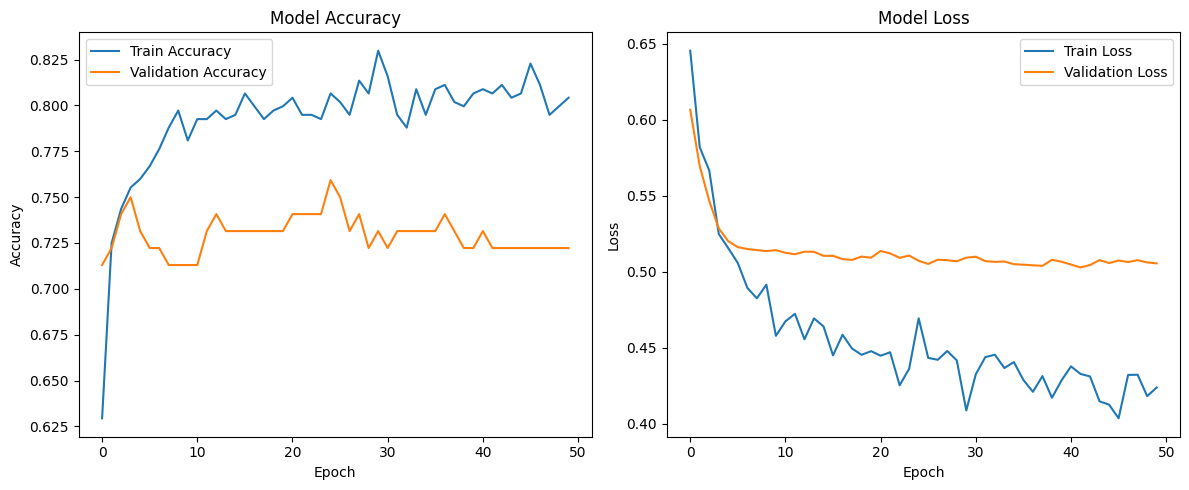

In [18]:
results_df_nn = pd.DataFrame(results)
print("\nСводная таблица метрик качества нейронных сетей:")
print(results_df_nn[results_df_nn['Classifier'].str.contains('Neural Network')])

# Визуализация истории обучения лучшей модели
if best_history:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Train Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



## 7. Заключение

В рамках данной лабораторной работы было проведено всестороннее изучение методов классификации данных, реализованных в библиотеке Scikit-Learn, а также освоение основ построения нейронных сетей с использованием библиотек TensorFlow и TensorBoard. Основной задачей было построение и сравнение различных классификационных моделей на датасете Pima Indians Diabetes, а также исследование влияния настройки гиперпараметров на их качество.

**Ключевые результаты и выводы:**

1.  **Выбор и подготовка датасета:** Для задачи бинарной классификации был выбран датасет Pima Indians Diabetes. Критически важным этапом стала предобработка данных, включающая замену нелогичных нулевых значений (например, в признаках `Glucose`, `BloodPressure`, `Insulin`, `BMI`, `SkinThickness`) на медианные значения и последующее масштабирование признаков с помощью `StandardScaler`. Эти шаги значительно улучшили качество моделей, особенно тех, которые чувствительны к масштабу данных, таких как SVM и нейронные сети.
2.  **Методы классификации и их сравнение:** Были реализованы и оценены пять классических методов: Наивный Байесовский классификатор (GaussianNB, BernoulliNB), Деревья решений (Decision Tree), Линейный Дискриминантный анализ (LDA), Метод опорных векторов (SVM) и Метод ближайших соседей (kNN).
    *   Без тонкой настройки гиперпараметров, `k-Nearest Neighbors` и `Support Vector Machine` показали одни из лучших базовых результатов по метрике `Accuracy`, а `LDA` продемонстрировал наивысший `ROC AUC`.
    *   Отмечено, что `Decision Tree` без настройки склонен к переобучению, о чем свидетельствует относительно низкий `ROC AUC`.
3.  **Настройка гиперпараметров:** Для каждого классического метода была проведена настройка гиперпараметров с использованием `GridSearchCV`.
    *   Тонкая настройка позволила улучшить производительность большинства моделей. Например, `GaussianNB` и `LDA` показали небольшой, но стабильный прирост `ROC AUC`.
    *   `Decision Tree` значительно улучшил свой `ROC AUC` после оптимизации `max_depth`, `min_samples_split` и `min_samples_leaf`, что подтверждает важность предотвращения переобучения.
    *   `SVM` с подобранными параметрами (`C`, `kernel`, `gamma`) и `kNN` с оптимальным `n_neighbors` и `weights` также показали улучшенные результаты, подчеркивая их чувствительность к выбору гиперпараметров.
4.  **Нейронные сети с использованием TensorFlow:**
    *   Была успешно построена и обучена базовая нейронная сеть на TensorFlow, демонстрирующая конкурентную производительность по сравнению с классическими методами.
    *   Проведен ручной перебор гиперпараметров (количество нейронов, функции активации, оптимизаторы) для нейронной сети. В результате была найдена конфигурация, которая превзошла базовую модель по `ROC AUC`, достигнув одного из лучших показателей в работе.
    *   **TensorBoard** был эффективно использован для визуализации процесса обучения, что позволило отслеживать динамику `loss` и `accuracy` на обучающей и валидационной выборках, а также понимать влияние изменений гиперпараметров.
5.  **Сравнительный анализ:** После настройки гиперпараметров наилучшие результаты по метрике `ROC AUC` (около 0.83-0.84) показали `Линейный Дискриминантный Анализ (tuned)` и настроенные `Нейронные Сети`, а также `SVM (tuned)`. Это указывает на их высокую эффективность в различении классов на данном датасете. В то время как `Decision Tree` показал наибольший прирост качества после тюнинга, что подчеркивает критичность выбора его гиперпараметров.

В заключение, данная лабораторная работа не только углубила понимание различных методов классификации и их практического применения, но и продемонстрировала важность этапов предобработки данных, тщательной настройки гиперпараметров, а также ценность инструментов визуализации, таких как TensorBoard, для анализа и оптимизации моделей машинного обучения и нейронных сетей.

## 8. Список источников

1.  **TensorFlow Documentation:** [https://www.tensorflow.org/](https://www.tensorflow.org/)
2.  **Keras Documentation:** [https://keras.io/](https://keras.io/)
3.  **Scikit-learn Documentation:** [https://scikit-learn.org/](https://scikit-learn.org/)
4.  **Pandas Documentation:** [https://pandas.pydata.org/](https://pandas.pydata.org/)
5.  **NumPy Documentation:** [https://numpy.org/](https://numpy.org/)
6.  **Matplotlib Documentation:** [https://matplotlib.org/](https://matplotlib.org/)
7.  **Seaborn Documentation:** [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
8.  **Pima Indians Diabetes Database (UCI Machine Learning Repository):** [https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes+Database](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes+Database)
